# DermalScan — AI Facial Skin Aging Detection

### MODULE 1: DATASET SETUP & INSPECTION

In [1]:
import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import zipfile
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
zip_path = "/content/DATASET.zip"  # path to your ZIP file
dataset_base = "/content/dataset"  # folder where we'll extract

# Define your 4 categories
categories = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]

# Extract only if not already extracted
if not os.path.exists(dataset_base):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_base)
        print("✅ Dataset extracted successfully!")
else:
    print("✅ Dataset already extracted!")

✅ Dataset extracted successfully!


In [4]:
dataset_base = "/content/dataset/DATASET"
print(os.listdir(dataset_base))

['.DS_Store', 'wrinkles', 'clear skin', 'puffy eyes', 'dark spots']


In [5]:
# Rename folders to consistent underscore format
rename_map = {
    "dark spots": "dark_spots",
    "puffy eyes": "puffy_eyes",
    "clear skin": "clear_skin"
}

for old, new in rename_map.items():
    old_path = os.path.join(dataset_base, old)
    new_path = os.path.join(dataset_base, new)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"✅ Renamed: '{old}' → '{new}'")

# Check the final folder list
print("\nFinal folders:", os.listdir(dataset_base))

✅ Renamed: 'dark spots' → 'dark_spots'
✅ Renamed: 'puffy eyes' → 'puffy_eyes'
✅ Renamed: 'clear skin' → 'clear_skin'

Final folders: ['.DS_Store', 'wrinkles', 'dark_spots', 'puffy_eyes', 'clear_skin']


In [6]:
categories = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]

In [7]:
class_counts = {cat: len(os.listdir(os.path.join(dataset_base, cat))) for cat in categories}

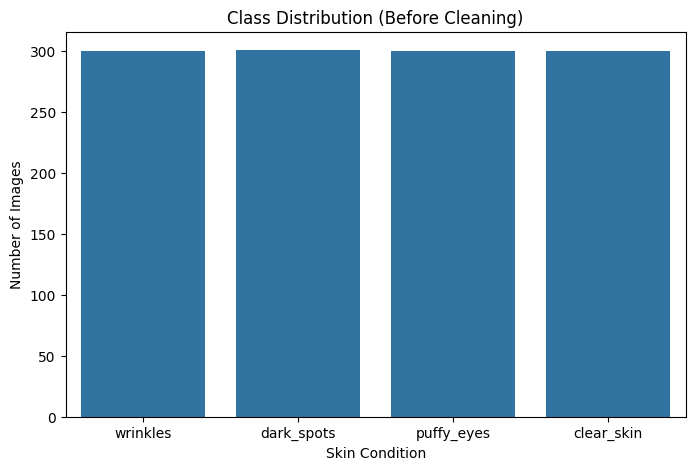


Class Counts: {'wrinkles': 300, 'dark_spots': 301, 'puffy_eyes': 300, 'clear_skin': 300}


In [10]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution (Before Cleaning)")
plt.ylabel("Number of Images")
plt.xlabel("Skin Condition")
plt.show()

print("\nClass Counts:", class_counts)

In [11]:
# Clean and validate images (remove corrupt ones)
def clean_images(base_path, categories):
    removed = 0
    for category in categories:
        folder = os.path.join(base_path, category)
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            try:
                img = cv2.imread(file_path)
                if img is None or img.size == 0:
                    os.remove(file_path)
                    removed += 1
            except:
                os.remove(file_path)
                removed += 1
    print(f"🧹 Removed {removed} corrupted images.")

clean_images(dataset_base, categories)

🧹 Removed 0 corrupted images.


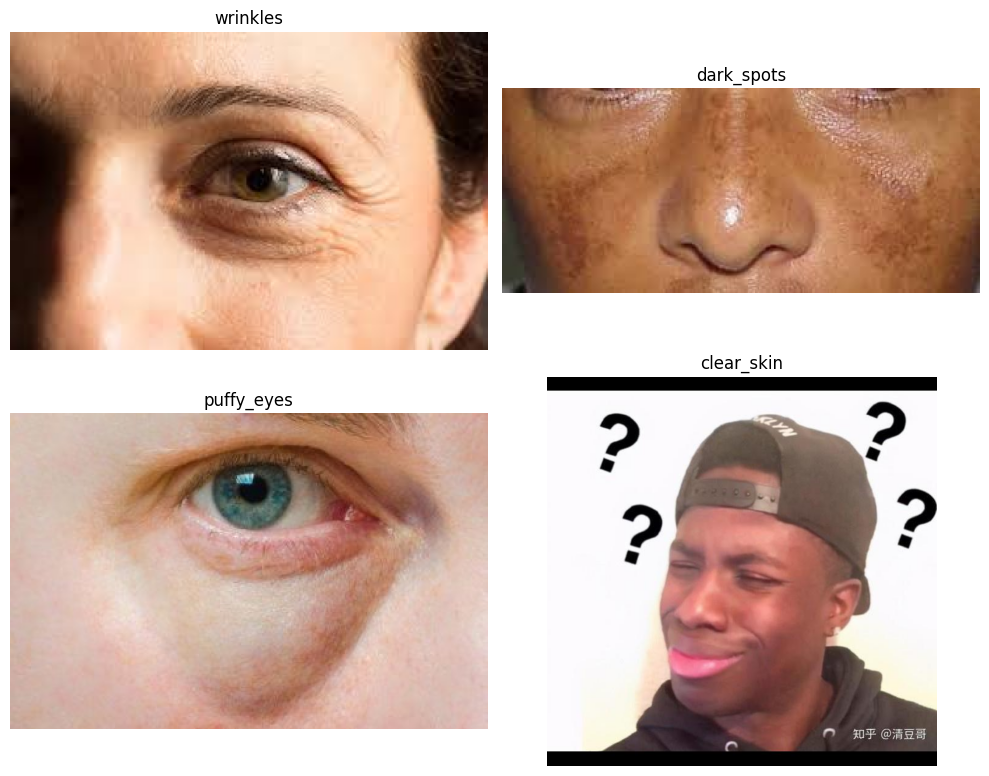

In [12]:
# Visualize random samples
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    folder = os.path.join(dataset_base, category)
    img_file = random.choice(os.listdir(folder))
    img = load_img(os.path.join(folder, img_file))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

### MODULE 2: IMAGE PREPROCESSING & AUGMENTATION

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [15]:
# Create ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [16]:
# Load training and validation sets
train_gen = datagen.flow_from_directory(
    dataset_base,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_base,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 961 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


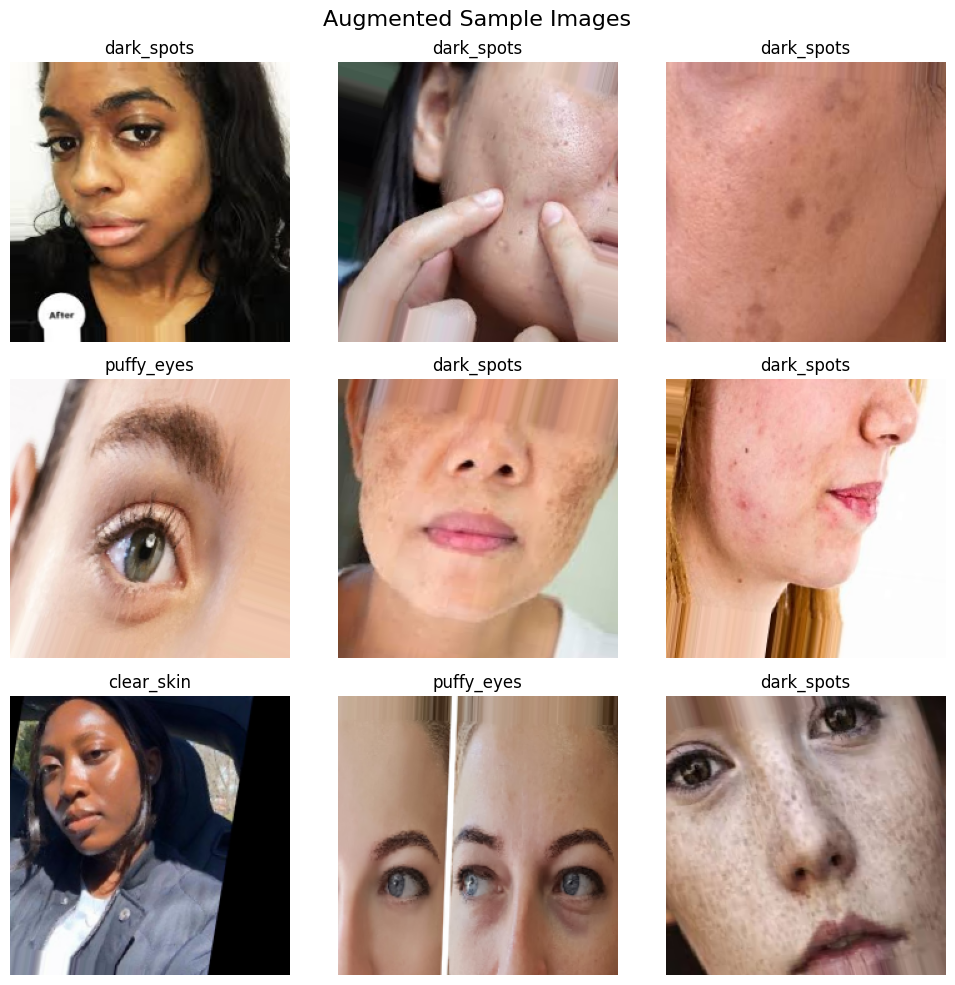

In [17]:
# Visualize Augmented Samples
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    label = list(train_gen.class_indices.keys())[np.argmax(y_batch[i])]
    plt.title(label)
    plt.axis('off')
plt.suptitle("Augmented Sample Images", fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# One-hot encoding check
print("✅ Class indices:", train_gen.class_indices)

✅ Class indices: {'clear_skin': 0, 'dark_spots': 1, 'puffy_eyes': 2, 'wrinkles': 3}
